# House Prices - Advanced Regression Techniques
## Predict sales prices and practice feature engineering, RFs, and gradient boosting

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview
    

## Part 1: Analyzing data

In [253]:
# Imports
import torch
import math, time
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

In [3]:
# Load data
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

In [4]:
test.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [5]:
train.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [6]:
# We have 1 column more
train.columns.size, test.columns.size

(81, 80)

In [7]:
# So test doesn't have SalePrice
diff = set(train.columns) - set(test.columns)
diff

{'SalePrice'}

In [8]:
# So I assume the test set is for submitting the results
# I will have to use the train as my main dataset, with SalePrice as target value
dataset = train
X = dataset[test.columns]
y = dataset['SalePrice']
X.shape,y.shape

((1460, 80), (1460,))

In [9]:
# Are there missing values?
missing_values = X.columns[X.isnull().sum() > 0].tolist()
X[missing_values].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [10]:
y.isnull().sum()

0

In [11]:
# Lets see straight ahead what can we achieve when considering all the features.
# We'll ignore for now the features with missing values.

### Pre-process data

# Separate data Xm will be X without features with missing values
Xm = X.drop(columns=missing_values)
print(Xm.columns)

# Select the numerical columns
numerical_columns = Xm.select_dtypes(include=['int', 'float']).columns
X_num = Xm.loc[:, numerical_columns]

# Select the categorical columns
categorical_columns = Xm.select_dtypes(include=['object']).columns
X_cat = Xm.loc[:, categorical_columns]

print('Numerical columns:', numerical_columns.size)
print('Categorical columns:', categorical_columns.size)
print('Total:', categorical_columns.size + numerical_columns.size, " Valid: ", Xm.shape[1] == categorical_columns.size + numerical_columns.size)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageCars', 'GarageArea', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')
Numerical columns: 34
Categorical columns: 27
Total: 61  Vali

In [12]:
numerical_columns, categorical_columns

(Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
       dtype='object'),
 Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating',
        'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive',
        'SaleType', 'SaleCondition'],
       dtype='object'))

- Scaling numerical data is pretty straightforward, we have to standarize data so the data looks like a standart distribution which makes data comparable and so, machine learning estimators can behave as intended.
- Encoding categorical features is a bit more complicated, because we have to decide if we are going to encode it with an ordinal encoder or not. So for this experiment, I'm gonna go with just get dummies wich is for non ordinal encoding. Which means its going to create new columns with only 0 and 1, instead of turning the labels into a column with 0, 1, 2, 3... because if I do that, the model might learn that 3 > 1 which is not the case for example with colors.

In [13]:
# Preprocess the numerical features
scaler = StandardScaler()

X_num = scaler.fit_transform(X_num)

# Encode the categorical features
X_cat = pd.get_dummies(X_cat)

In [14]:
print(X_num.shape, X_cat.shape)

(1460, 34) (1460, 182)


In [15]:
X_merged = pd.concat([pd.DataFrame(X_num, columns=numerical_columns), pd.DataFrame(X_cat)], axis=1)
X_merged.shape

(1460, 216)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_merged, y, test_size=0.2, random_state=0)

In [17]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 216) (292, 216) (1168,) (292,)


In [18]:
print(y_train.dtype, y_test.dtype)

int64 int64


In [19]:
# Choose a regression algorithm
regressor = LinearRegression()

# Train the regression model
regressor.fit(X_train, y_train);

In [20]:
# Evaluate the performance of the model
y_pred = regressor.predict(X_test)
print(y_test.shape, y_test.shape)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

(292,) (292,)
Mean Squared Error: 4323736233256735788303908864.00
Mean Absolute Error: 8226226617921.66


In [21]:
# Baseline approach results
results[0:100], results[100:200], results[200:]

(    Original  Predicted
 0   200624.0   275109.0
 1   133000.0   145210.0
 2   110000.0   117224.0
 3   192000.0   216340.0
 4    88000.0    98508.0
 ..       ...        ...
 95  157000.0   166554.0
 96  213000.0   213814.0
 97  185000.0   163470.0
 98  124500.0   106210.0
 99  162900.0   158950.0
 
 [100 rows x 2 columns],
      Original  Predicted
 100  260000.0   249340.0
 101  198500.0   236068.0
 102  120000.0   112726.0
 103  159500.0   152850.0
 104  105900.0   105946.0
 ..        ...        ...
 195  142500.0   150840.0
 196   80000.0    65056.0
 197  145000.0   144488.0
 198  171000.0   171700.0
 199  122500.0   118338.0
 
 [100 rows x 2 columns],
      Original  Predicted
 200  139000.0   116426.0
 201  189000.0   219712.0
 202  120500.0   114692.0
 203  124000.0   132612.0
 204  160000.0   110126.0
 ..        ...        ...
 287  324000.0   284284.0
 288  555000.0   460834.0
 289  136000.0   264300.0
 290   82500.0   127678.0
 291  101000.0   101224.0
 
 [92 rows x 2 column

- It shows a very big number for the MSE as well as MAE, and that's because the target data is in it's original price value, but if we look at the predictions, doesn't look so off the original value considering we haven't touched too much the data.
- So after we are done with cleaning most of the data, we'll start trying some feature selection techniques and other models.

In [123]:
# Some min max data of prices
min(y), max(y)

(34900, 755000)

## Part 2: Missing data
- We trained a simple regression model using all the data that had no missing values.
- But if we look at the missing data, there are some features that have only few missing parts that could be imputed so we have more features available.

In [22]:
X[missing_values].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [23]:
# Lets say we want to take into account these extra data
# Let's consider the ones with less than 100 missing points.

incomplete = X.columns[X.isnull().sum() > 0].tolist()
incomplete100 = X.columns[X.isnull().sum() <= 100].tolist()
incomplete_columns = list(set(incomplete) & set(incomplete100))
print(np.sort(incomplete_columns))

['BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'BsmtQual'
 'Electrical' 'GarageCond' 'GarageFinish' 'GarageQual' 'GarageType'
 'GarageYrBlt' 'MasVnrArea' 'MasVnrType']


In [24]:
X[incomplete_columns]

,BsmtFinType1,MasVnrArea,GarageYrBlt,MasVnrType,BsmtQual,GarageType,GarageFinish,GarageQual,BsmtFinType2,BsmtCond,BsmtExposure,GarageCond,Electrical
0,GLQ,196.0,2003.0,BrkFace,Gd,Attchd,RFn,TA,Unf,TA,No,TA,SBrkr
1,ALQ,0.0,1976.0,None,Gd,Attchd,RFn,TA,Unf,TA,Gd,TA,SBrkr
2,GLQ,162.0,2001.0,BrkFace,Gd,Attchd,RFn,TA,Unf,TA,Mn,TA,SBrkr
3,ALQ,0.0,1998.0,None,TA,Detchd,Unf,TA,Unf,Gd,No,TA,SBrkr
4,GLQ,350.0,2000.0,BrkFace,Gd,Attchd,RFn,TA,Unf,TA,Av,TA,SBrkr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,Unf,0.0,1999.0,None,Gd,Attchd,RFn,TA,Unf,TA,No,TA,SBrkr
1456,ALQ,119.0,1978.0,Stone,Gd,Attchd,Unf,TA,Rec,TA,No,TA,SBrkr
1457,GLQ,0.0,1941.0,None,TA,Attchd,RFn,TA,Unf,Gd,No,TA,SBrkr
1458,GLQ,0.0,1950.0,None,TA,Attchd,Unf,TA,Rec,TA,Mn,TA,FuseA


- Let's take a look at the descriptions for each one

1. 'BsmtCond': Evaluates the general condition of the basement
2. 'BsmtExposure': Refers to walkout or garden level walls
3. 'BsmtFinType1': Rating of basement finished area
4. 'BsmtFinType2': Rating of basement finished area (if multiple types)
5. 'BsmtQual': Height of the basement
6. 'Electrical': Electrical system
7. 'GarageCond': Garage condition
8. 'GarageFinish': Interior finish of the garage
9. 'GarageQual': Garage quality
10. 'GarageType': Garage location
11. 'GarageYrBlt': Year garage was built
12. 'MasVnrArea': Masonry veneer area in square feet
13. 'MasVnrType': Masonry veneer type
    
 
 - So at first glance, appears obvious that the missing data could be because the house doesn't have a basement or garage. The electrical system seems a bit less obvious one, and might be because of actual missing data because it's just 1 data that has no electrical system. I don't actually know about masonry veneer so I had to ask my friend ChatGPT which said:
 
   Masonry veneer is a type of exterior cladding that provides a **beautiful and durable finish** to a building's façade. There are several types of masonry veneer, including:

    **Brick veneer**: This is the most common type of masonry veneer. It is made up of a layer of bricks that are placed over a frame or wall. The bricks are typically held in place with mortar.

    **Stone veneer**: This type of veneer is made up of thin pieces of natural or manufactured stone that are attached to a frame or wall. Stone veneer can be used to achieve a wide range of aesthetic styles, from rustic to modern.

    **Stucco veneer**: Stucco is a mixture of cement, sand, and water that is applied to a wall or frame to create a smooth or textured finish. Stucco veneer can be colored and textured to mimic the appearance of other types of masonry.

    **Concrete block veneer**: Concrete blocks can be used as a veneer to achieve a modern, industrial look. The blocks can be left unfinished or painted to create a specific aesthetic.

    **Terra cotta veneer**: Terra cotta is a type of clay that can be molded into various shapes and sizes. Terra cotta veneer is a lightweight option that is often used for decorative features, such as window surrounds or cornices.

In [25]:
# Processing: MasVnrType & MasVnrArea
X['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [26]:
X[X['MasVnrType'].isnull()]['MasVnrArea']

234    NaN
529    NaN
650    NaN
936    NaN
973    NaN
977    NaN
1243   NaN
1278   NaN
Name: MasVnrArea, dtype: float64

- In this case we have in MasVnrType a category 'None' which we could use it to default the missing values, and for MasVnrArea we also can see in the data that some have 0.0, which could also work as a default value. We also don't have any more data about the masonry veneer to make us think that there is missing data and instead of 0 or None it could be another category, so best way would be set the values to default.
- Also happens that missing data from 'MasVnrArea' are the same rows, so we can default it to 0.

In [27]:
X.loc[X['MasVnrType'].isnull(), 'MasVnrType'] = 'None'
X.loc[X['MasVnrArea'].isnull(), 'MasVnrArea'] = 0.0
X['MasVnrType'].isnull().sum(), X['MasVnrType'].isnull().sum()

(0, 0)

In [28]:
# Processing: Electrical
X['Electrical'].value_counts(), X['Electrical'].unique()

(SBrkr    1334
 FuseA      94
 FuseF      27
 FuseP       3
 Mix         1
 Name: Electrical, dtype: int64,
 array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object))

In [29]:
# Let's print this 1 row
X[X['Electrical'].isnull()], y[X['Electrical'].isnull()]
# We can see that it has the Utilities feature set to 'AllPub': All public Utilities (E,G,W,& S).
# I wouldn't mess much with only 1 datapoint
# so I'll set it to the average Electrical System: SBrkr Standard Circuit Breakers & Romex

(        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 1379  1380          80       RL         73.0     9735   Pave   NaN      Reg   
 
      LandContour Utilities  ... ScreenPorch PoolArea PoolQC Fence MiscFeature  \
 1379         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
 
      MiscVal MoSold  YrSold  SaleType  SaleCondition  
 1379       0      5    2008        WD         Normal  
 
 [1 rows x 80 columns],
 1379    167500
 Name: SalePrice, dtype: int64)

In [30]:
X.loc[X['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
X['Electrical'].isnull().sum()

0

In [31]:
# Processing: Basement
bsmt_columns = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
X[bsmt_columns].isnull().sum()

BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
BsmtQual        37
dtype: int64

In [32]:
X[bsmt_columns][X['BsmtExposure'].isnull()] # I use basement exposure because has 38 missing values

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN
371,NaN,NaN,NaN,NaN,NaN


In [33]:
X[bsmt_columns][X['BsmtFinType2'].isnull()] # BsmtFinType2 also had 38 values, but the row 948 had BsmtFinType2 as a non null

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
332,TA,No,GLQ,NaN,Gd
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN


- If we take a look, we can see that almost all the missing data from the basement comes from the same houses.
- We could just assume that those houses don't have a basement, but we have to look just in case there is some inconsistent data, for example, another feature that has a label which indicates the pressence of a basement.
- What other features consider a basement? and how it tells us if there is no basement?


In [34]:
for b in bsmt_columns:
    print(X[b].value_counts(), "\n")

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64 

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64 

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64 

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64 

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64 



- If we take a look at the data description we have that we have for example:

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
      
- There were only 2 rows with filled data
- Rows:

        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual'

- BsmtExposure NaN

        948 	TA 	NaN 	Unf 	Unf 	Gd

- BsmtFinType2 NaN

        332 	TA 	No 	GLQ 	NaN 	Gd
        
        
- But both are valid since they meet the relation, because has TA as Basement condition, we know it has a basement but BsmtExposure is NaN, which could mean that it has no exposue of the basement, because the other data gives me indications that it has a basement.
- And in the case of BsmtFinType2 is the same, we can complete it with Unf.
     

In [35]:
X.loc[948, 'BsmtExposure'] = 'No'
X.loc[332, 'BsmtFinType2'] = 'Unf'

In [36]:
X[bsmt_columns].isnull().sum()

BsmtCond        37
BsmtExposure    37
BsmtFinType1    37
BsmtFinType2    37
BsmtQual        37
dtype: int64

- So now we can complete this data and fill those values with the NA category

In [37]:
for i in bsmt_columns:
    X.loc[X[i].isnull(), i] = 'NA'

In [38]:
X[bsmt_columns].isnull().sum()

BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
dtype: int64

- Let's check again the missing data

In [39]:
X[missing_values].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         0
MasVnrArea         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinType2       0
Electrical         0
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [40]:
garage_columns = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond"]

In [41]:
# Let's check how many data has missing for every garage column
for i in garage_columns:
    print(len(X[i][X[i].isnull()]))

81
81
81
81
81


In [42]:
# Are they all the same?
indexes = []
for i in garage_columns:
    indexes.append(list(X[i][X[i].isnull()].index))
are_equal = True
for i in range(len(indexes) - 1):
    for j in range(i + 1, len(indexes)):
        if indexes[i] != indexes[j]:
            are_equal = False
            break
if are_equal:
    print("Equal")
else:
    print("Different")

Equal


- Here we encounter one problem. We could fill almost all these categories with NA for no garage, but because there is no garage, we can't fill the column GarageYrBlt with 0. So in this case we'll leave this from our features.

GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: Year garage was built
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

In [43]:
garage_columns = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"] # Removed year built garage

In [44]:
# Filling the columns with data
for i in garage_columns:
    X.loc[X[i].isnull(), i] = 'NA'

In [45]:
# Check again
for i in garage_columns:
    print(len(X[i][X[i].isnull()]))

0
0
0
0


## Part 3: Testing our new features

In [46]:
# Get all our new filled columns names
null_sum = X[missing_values].isnull().sum()
new_columns = null_sum[null_sum == 0].index.tolist()
new_columns, len(new_columns)

(['MasVnrType',
  'MasVnrArea',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Electrical',
  'GarageType',
  'GarageFinish',
  'GarageQual',
  'GarageCond'],
 12)

### Concat old and new data, and apply the same process from the Part 1

In [47]:
# Save last values
X_num_old = X_num
X_cat_old = X_cat
numerical_columns_old = numerical_columns
categorical_columns_old = categorical_columns
print(numerical_columns, categorical_columns)
# Get all the data from the columns that was missing before
X_miss = X[new_columns]

# Select the numerical columns
numerical_columns = X_miss.select_dtypes(include=['int', 'float']).columns
X_num = X_miss.loc[:, numerical_columns]

# Select the categorical columns
categorical_columns = X_miss.select_dtypes(include=['object']).columns
X_cat = X_miss.loc[:, categorical_columns]

print('Numerical columns:', numerical_columns.size)
print('Categorical columns:', categorical_columns.size)
print('Total:', categorical_columns.size + numerical_columns.size, " Valid: ", X_miss.shape[1] == categorical_columns.size + numerical_columns.size)

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object') Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating',
       'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')
Numerical columns: 1
Categorical colum

In [48]:
numerical_columns, categorical_columns

(Index(['MasVnrArea'], dtype='object'),
 Index(['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
        'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish',
        'GarageQual', 'GarageCond'],
       dtype='object'))

In [49]:
# Concatenate the data
numerical_columns = np.concatenate((numerical_columns_old, numerical_columns), axis=0)
categorical_columns = np.concatenate((categorical_columns_old, categorical_columns), axis=0)

numerical_columns, numerical_columns.shape, categorical_columns, categorical_columns.shape

(array(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
        'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MasVnrArea'],
       dtype=object),
 (35,),
 array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
        'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual',
        'Functional', 'PavedDrive', 'SaleType', 'SaleCondition',
        'MasVnrTyp

In [50]:
X_num = X.loc[:, numerical_columns]
X_cat = X.loc[:, categorical_columns]
X_num.shape, X_cat.shape

((1460, 35), (1460, 38))

In [51]:
# Preprocess the numerical features
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Encode the categorical features
X_cat = pd.get_dummies(X_cat)

print(X_num.shape, X_cat.shape)

(1460, 35) (1460, 243)


In [52]:
X_merged = pd.concat([pd.DataFrame(X_num, columns=numerical_columns), pd.DataFrame(X_cat)], axis=1)
X_merged.shape, X_merged.columns

((1460, 278),
 Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        ...
        'GarageQual_Gd', 'GarageQual_NA', 'GarageQual_Po', 'GarageQual_TA',
        'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_NA',
        'GarageCond_Po', 'GarageCond_TA'],
       dtype='object', length=278))

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_merged, y, test_size=0.2, random_state=0)

In [54]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 278) (292, 278) (1168,) (292,)


In [55]:
print(y_train.dtype, y_test.dtype)

int64 int64


In [56]:
# Reinstantiate the regressor
regressor = LinearRegression()

# Train the regression model
regressor.fit(X_train, y_train);

In [57]:
# Evaluate the performance of the model
y_pred = regressor.predict(X_test)
print(y_test.shape, y_test.shape)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

(292,) (292,)
Mean Squared Error: 133510241737180368806206242816.00
Mean Absolute Error: 37936496619715.09


In [58]:
# Baseline approach results
results[0:100], results[100:200], results[200:]

(    Original  Predicted
 0   200624.0   266300.0
 1   133000.0   144288.0
 2   110000.0   108044.0
 3   192000.0   209948.0
 4    88000.0    95928.0
 ..       ...        ...
 95  157000.0   156164.0
 96  213000.0   210044.0
 97  185000.0   160772.0
 98  124500.0   112272.0
 99  162900.0   160800.0
 
 [100 rows x 2 columns],
      Original  Predicted
 100  260000.0   245316.0
 101  198500.0   235716.0
 102  120000.0   118236.0
 103  159500.0   145284.0
 104  105900.0   105456.0
 ..        ...        ...
 195  142500.0   159328.0
 196   80000.0    61960.0
 197  145000.0   135132.0
 198  171000.0   169412.0
 199  122500.0   120052.0
 
 [100 rows x 2 columns],
      Original  Predicted
 200  139000.0   114632.0
 201  189000.0   206772.0
 202  120500.0   117940.0
 203  124000.0   128208.0
 204  160000.0   132216.0
 ..        ...        ...
 287  324000.0   299860.0
 288  555000.0   471676.0
 289  136000.0   252120.0
 290   82500.0   110576.0
 291  101000.0    96208.0
 
 [92 rows x 2 column

- So the error has gone worse, but on the other hand, this was just a simple test, the good thing is we have more features to consider.

## Part 4: Feature Selection

 - We've been using a simple regression model, but for a problem like this, there are better models that also offer more interpretability like Random Forests. But first, we'll use some feature selection methods, and see how much we can improve the accuracy of our model, and then see the difference between the regression one and the random forest.
 - Right now the training time is barely noticeable and we don't have a LOT of features, 278 doesn't seem too much right now, so we could probably use a greedier method instead of going with a filter method first, to see if we can reduce the features to a smaller number.
 - I have an assumption that maybe because a lot of features are used to describe a characteristic like for example the garage, all the garage features could be highly correlated, so we could remove many of those features OR create a new feature with them.
 - The method I would like to test is scikit-learn's Sequential Feature Selection, but first I would like to clean my feature s a little bit, and see if there are features that have very low variance (almost the same values in all observations).

In [59]:
from sklearn.feature_selection import VarianceThreshold
# Variance threshold of 5%
sel = VarianceThreshold(threshold=(0.05))
sel.feature_names_in_=X_merged.columns
print(X_merged.shape)
X_var = sel.fit_transform(X_merged)
print(X_var.shape)
selected_features = sel.get_support()
selected_columns = X_merged.columns[selected_features]
# So basically we've removed all features which had >=95% zeros in all observations

(1460, 278)
(1460, 123)


- Until now I've been looking at a feature, the first one "Id", I didn't want to arbitrarily remove it until now so if we can see if the feature selection method can remove it.

- Following what recommends the official page of Sequential Feature Selection https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py

- We use RidgeCV which is a regression model that uses cross validation for selecting the most important feature.
- Regression feature selection works by fitting a model and extracting the betas/coefficients of each feature.


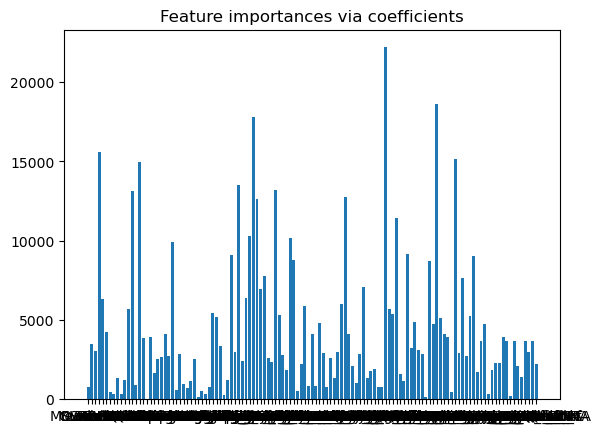

In [60]:
from sklearn.linear_model import RidgeCV
# 
ridge = RidgeCV().fit(X_var, y)
importance = np.abs(ridge.coef_) # Extract coefficients
plt.bar(height=importance, x=selected_columns)
plt.title("Feature importances via coefficients")
plt.show()

- Which gives us the following top 5 features

In [61]:
# Make list of values
importance_features = list(zip(selected_columns, importance))

# Sort the list of tuples by values in descending order and select top 5 tuples
top5 = sorted(importance_features, key=lambda x: x[1], reverse=True)[:5]

# Extract column names from selected tuples
top5_features = [t[0] for t in top5]
top5_features

['KitchenQual_Ex',
 'BsmtQual_Ex',
 'Neighborhood_Edwards',
 'OverallQual',
 'BsmtExposure_Gd']

- Following the example instructions, we want to select the best features from the model, so then we can use the sequential feature selection which adds the next best feature

In [62]:
from sklearn.feature_selection import SelectFromModel

# Selects the threshold of the third best feature importance
threshold = np.sort(importance)[-3] + 0.01

tic = time.time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(X_var, y)
toc = time.time()

print(f"Features selected by SelectFromModel: {selected_columns[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: Index(['KitchenQual_Ex', 'BsmtQual_Ex'], dtype='object')
Done in 0.010s


- And now finally we use the SequentialFeatureSelector
- We can do a forward selection where we start with the 2 features and then we add 1 feature and see if the new subset improves or not, with backwards is the opposite

In [63]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time.time()
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=20, direction="forward"
).fit(X_var, y)
toc_fwd = time.time()

tic_bwd = time.time()
sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=20, direction="backward"
).fit(X_var, y)
toc_bwd = time.time()

print(
    "Features selected by forward sequential selection: "
    f"{selected_columns[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print(
    "Features selected by backward sequential selection: "
    f"{selected_columns[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by forward sequential selection: Index(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1',
       'GrLivArea', 'BsmtFullBath', 'Fireplaces', 'GarageCars', 'MSZoning_RM',
       'LotConfig_CulDSac', 'Neighborhood_Edwards', 'Neighborhood_NAmes',
       'Condition1_Norm', 'ExterQual_TA', 'KitchenQual_Ex', 'Functional_Typ',
       'BsmtQual_Ex', 'BsmtExposure_Gd', 'GarageType_NA'],
      dtype='object')
Done in 13.894s
Features selected by backward sequential selection: Index(['OverallQual', 'OverallCond', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath',
       'GarageCars', 'WoodDeckSF', 'LotConfig_CulDSac', 'Neighborhood_Edwards',
       'Neighborhood_OldTown', 'Condition1_Norm', 'BldgType_1Fam',
       'HouseStyle_1Story', 'ExterQual_TA', 'KitchenQual_Ex', 'Functional_Typ',
       'BsmtQual_Ex', 'BsmtExposure_Gd', 'BsmtFinType1_Unf', 'GarageCond_NA'],
      dtype='object')
Done in 147.237s


### Evaluation
- You see that? The feature selection method selected some features from the variables with missing values we fixed, so it was worth fixing!

- The columns we had with missing values were: 


      'MasVnrType',
      'MasVnrArea',
      'BsmtQual',
      'BsmtCond',
      'BsmtExposure',
      'BsmtFinType1',
      'BsmtFinType2',
      'Electrical',
      'GarageType',
      'GarageFinish',
      'GarageQual',
      'GarageCond'
  
- From this, we have BsmtQual_Ex, BsmtExposure_Gd, BsmtFinType1_Unf, GarageType_NA, in forward selection.
- And BsmtQual_Ex, BsmtExposure_Gd, BsmtFinType1_Unf, GarageCond_NA, for backward selection.
- Now let's train our model with these features.

In [64]:
features_forward = selected_columns[sfs_forward.get_support()]
features_backward = selected_columns[sfs_backward.get_support()]
X_forward = X_merged[features_forward]
X_backward = X_merged[features_backward]
X_forward.shape, X_backward.shape

((1460, 20), (1460, 20))

In [65]:
# Evaluate forward selection
X_train, X_test, y_train, y_test = train_test_split(X_forward, y, test_size=0.2, random_state=0)

In [66]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 20) (292, 20) (1168,) (292,)


In [67]:
print(y_train.dtype, y_test.dtype)

int64 int64


In [68]:
regressor = LinearRegression()
regressor.fit(X_train, y_train);

In [69]:
# Evaluate the performance of the model
y_pred = regressor.predict(X_test)
print(y_test.shape, y_test.shape)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1).astype(np.int64)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

(292,) (292,)
Mean Squared Error: 1782201882.20
Mean Absolute Error: 21333.85


In [70]:
# Baseline approach results
results[0:100], results[100:200], results[200:]

(    Original  Predicted
 0     200624     257179
 1     133000     158205
 2     110000     118350
 3     192000     213994
 4      88000      92680
 ..       ...        ...
 95    157000     151721
 96    213000     214065
 97    185000     160320
 98    124500     110949
 99    162900     148214
 
 [100 rows x 2 columns],
      Original  Predicted
 100    260000     240447
 101    198500     204820
 102    120000     113194
 103    159500     158206
 104    105900     112458
 ..        ...        ...
 195    142500     163264
 196     80000      45023
 197    145000     137548
 198    171000     178003
 199    122500     108219
 
 [100 rows x 2 columns],
      Original  Predicted
 200    139000     122741
 201    189000     194540
 202    120500      97257
 203    124000     126671
 204    160000     138034
 ..        ...        ...
 287    324000     284805
 288    555000     440641
 289    136000     190666
 290     82500     101432
 291    101000      95884
 
 [92 rows x 2 column

In [71]:
# Evaluate forward selection
X_train, X_test, y_train, y_test = train_test_split(X_backward, y, test_size=0.2, random_state=0)

In [72]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 20) (292, 20) (1168,) (292,)


In [73]:
print(y_train.dtype, y_test.dtype)

int64 int64


In [74]:
regressor = LinearRegression()

regressor.fit(X_train, y_train);

In [75]:
# Evaluate the performance of the model
y_pred = regressor.predict(X_test)
print(y_test.shape, y_test.shape)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1).astype(np.int64)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

(292,) (292,)
Mean Squared Error: 1624204072.95
Mean Absolute Error: 21294.15


In [76]:
results[0:100], results[100:200], results[200:]

(    Original  Predicted
 0     200624     260110
 1     133000     156223
 2     110000     120740
 3     192000     216703
 4      88000      92684
 ..       ...        ...
 95    157000     154204
 96    213000     215771
 97    185000     164172
 98    124500     113525
 99    162900     154298
 
 [100 rows x 2 columns],
      Original  Predicted
 100    260000     237327
 101    198500     200983
 102    120000     118599
 103    159500     153639
 104    105900     112800
 ..        ...        ...
 195    142500     163228
 196     80000      51600
 197    145000     148061
 198    171000     178543
 199    122500     117043
 
 [100 rows x 2 columns],
      Original  Predicted
 200    139000     123819
 201    189000     198792
 202    120500     102852
 203    124000     116973
 204    160000     146596
 ..        ...        ...
 287    324000     276874
 288    555000     430158
 289    136000     196856
 290     82500     109984
 291    101000     106812
 
 [92 rows x 2 column

- Now we are talking, it improved a lot, but still we are a bit off.
- Considering we have selected some features based on a simple selection based on a regression technique, going from 278 features to 123, to 20 seems like a big jump.
- We could try different feature selection methods, but let's try our new features with another model and see how it behaves, for example with Random Forests, which can be used also for feature selection.
- But firstable, I want to know, Why the House N_0 got a prediction 60k higher than the original? Maybe the model is saying something like "Oh, so you have a showerdoor? That's gotta be an expensive house, I'll add 60k more to the final price.", Which obviously sounds completely bonkers. The problem with this is we don't want to introduce bias into our training. This means, don't use the outputted results as a new input to make the error smaller, because it will affect the ability of our model for generalization and predict unseen data accurately.
- A way to visualize this in a linear regression model is to look at the coefficients.

In [77]:
features_backward.to_list()

['OverallQual',
 'OverallCond',
 '1stFlrSF',
 '2ndFlrSF',
 'BsmtFullBath',
 'GarageCars',
 'WoodDeckSF',
 'LotConfig_CulDSac',
 'Neighborhood_Edwards',
 'Neighborhood_OldTown',
 'Condition1_Norm',
 'BldgType_1Fam',
 'HouseStyle_1Story',
 'ExterQual_TA',
 'KitchenQual_Ex',
 'Functional_Typ',
 'BsmtQual_Ex',
 'BsmtExposure_Gd',
 'BsmtFinType1_Unf',
 'GarageCond_NA']

In [78]:
coefficients = regressor.coef_
intercept = regressor.intercept_

manual_prediction = np.dot(X_test, coefficients) + intercept

print('Predicted value:', y_pred[0])
print('Manual prediction:', manual_prediction[0])
print('House N_0:', np.array(X_test)[0])
print('Coefficients', coefficients)
print('Intercept:', intercept)
print('Dot product[0]: ', np.dot(X_test, coefficients)[0])

reg_coef_data = pd.DataFrame(pd.concat([pd.DataFrame(np.array(X_test)[0]).T, pd.DataFrame(coefficients).T], axis=0))
reg_coef_data.columns = features_backward
reg_coef_data

Predicted value: 260110.16520017516
Manual prediction: 260110.16520017516
House N_0: [-0.07183611 -2.31508485  3.49942984 -0.79516323  1.10781015  0.31172464
 -0.75217584  1.          0.          0.          1.          1.
  1.          0.          0.          0.          0.          0.
  0.          0.        ]
Coefficients [ 19475.06553726   5062.87231804  27074.97144586  25773.0574573
   4429.17308278  10596.26891409   3164.92445117  13632.16689855
 -12381.73089462 -16806.11431005  14174.5538513   17373.66174043
   8858.91058393 -17112.54866921  34710.10616493  18335.77914267
  36244.42719535  22673.84323266  -9232.99827225  14501.15627744]
Intercept: 139108.4672923262
Dot product[0]:  121001.69790784895


,OverallQual,OverallCond,1stFlrSF,2ndFlrSF,BsmtFullBath,GarageCars,WoodDeckSF,LotConfig_CulDSac,Neighborhood_Edwards,Neighborhood_OldTown,Condition1_Norm,BldgType_1Fam,HouseStyle_1Story,ExterQual_TA,KitchenQual_Ex,Functional_Typ,BsmtQual_Ex,BsmtExposure_Gd,BsmtFinType1_Unf,GarageCond_NA
0,-0.071836,-2.315085,3.499430,-0.795163,1.107810,0.311725,-0.752176,1.000000,0.000000,0.00000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,19475.065537,5062.872318,27074.971446,25773.057457,4429.173083,10596.268914,3164.924451,13632.166899,-12381.730895,-16806.11431,14174.553851,17373.66174,8858.910584,-17112.548669,34710.106165,18335.779143,36244.427195,22673.843233,-9232.998272,14501.156277


- Let's take a look at the data from house N_0 (first row) and the coefficients (second row).
- Consider that the intercept value is 139108.46
- The feature that the model rates the highest is the BsmtQual_Ex with 36244.42 and the lowest one is ExterQual_TA with -17112.54.
- We can see that most negative coefficient values are not taken into account, which in some way is like saying that the features that the model knows it would reduce the price didn't got taken in account because the observation had 0 in every categorical data that it calculated.
- And this tells us that it's not enough features for this model to generalize in scenarios like this.

In [79]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train);

In [80]:
# Evaluate the performance of the model
y_pred = forest.predict(X_test)
print(y_test.shape, y_test.shape)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1).astype(np.int64)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

(292,) (292,)
Mean Squared Error: 1402045000.70
Mean Absolute Error: 25113.72


In [81]:
results[0:100], results[100:200], results[200:]

(    Original  Predicted
 0     200624     223000
 1     133000     130000
 2     110000     127000
 3     192000     222500
 4      88000      94500
 ..       ...        ...
 95    157000     139000
 96    213000     227000
 97    185000     110000
 98    124500     120500
 99    162900     112000
 
 [100 rows x 2 columns],
      Original  Predicted
 100    260000     260400
 101    198500     165400
 102    120000     131400
 103    159500     179900
 104    105900     110000
 ..        ...        ...
 195    142500     147000
 196     80000      80000
 197    145000     154500
 198    171000     195000
 199    122500     125000
 
 [100 rows x 2 columns],
      Original  Predicted
 200    139000     155000
 201    189000     254000
 202    120500     110000
 203    124000      93500
 204    160000     137000
 ..        ...        ...
 287    324000     275000
 288    555000     611657
 289    136000     143000
 290     82500      34900
 291    101000      78000
 
 [92 rows x 2 column

- So the model is not improving, at this point I think I should look more at the data, so I'll plot the top 5 features from the list.
- But how do I plot the binary categorical data? We can do it by plotting the different combinations of those versus the price target and see how they interact with the price.

In [106]:
X_backward[top5_features]

,KitchenQual_Ex,BsmtQual_Ex,Neighborhood_Edwards,OverallQual,BsmtExposure_Gd
0,0,0,0,0.651479,0
1,0,0,0,-0.071836,1
2,0,0,0,0.651479,0
3,0,0,0,0.651479,0
4,0,0,0,1.374795,0
...,...,...,...,...,...
1455,0,0,0,-0.071836,0
1456,0,0,0,-0.071836,0
1457,0,0,0,0.651479,0
1458,0,0,0,-0.795151,0


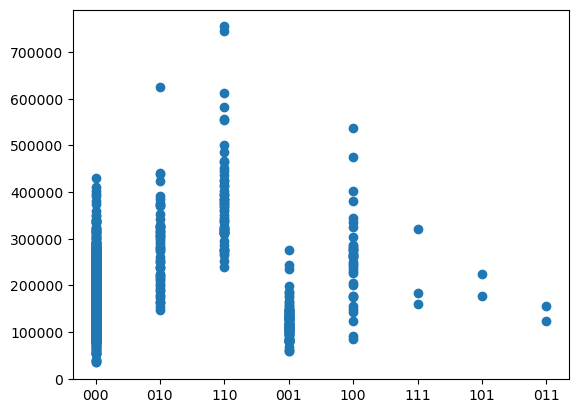

In [161]:
cat_features = ["KitchenQual_Ex", "BsmtQual_Ex", "Neighborhood_Edwards"]
data = X_backward[cat_features]

def get_binary_features(data, cat_features):
    binary_features = []
    for i in range(data.shape[0]):
        value = ""
        for f in cat_features:
            value += str(data[f][i])
        binary_features.append(value)
        value = ""
    return np.array(binary_features)

binary_features = get_binary_features(data, cat_features)

fig, ax = plt.subplots()
ax.scatter(binary_features, y);

- So just looking at it we can see that most of the lower price range houses don't have any of the features described above, the kitchen quality is not excelent, que basement quality is not excelent, and the neighborhood is not edwards
- While the houses of the most higher price range, have both the first qualities, but are not in the edwards neighborhood.
- Now I wanna see all neighborhoods that got selected.


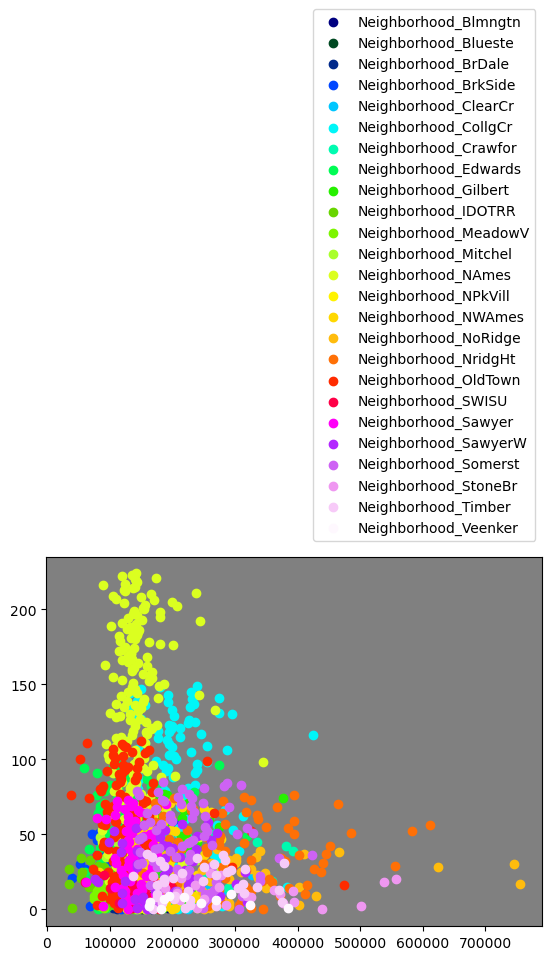

In [266]:
neighborhoods = [n for n in X_merged.columns if 'Neighborhood' in n]
neigh_ones = []
for n in neighborhoods:
    neigh_ones.append(y[X_merged[X_merged[n] == 1][n].index])
    
fig, ax = plt.subplots()
index = 0
colors = cm.gist_ncar(np.linspace(0, 1, len(neigh_ones)))
for no, c in zip(neigh_ones, colors):
    ax.scatter(no, range(len(no)), label=neighborhoods[index], color=colors[index])
    index+=1
ax.set_facecolor((0.5,0.5,0.5))
ax.legend(loc='upper right', bbox_to_anchor=(1, 2.5));

- I was thinking on considering more neighborhoods in the features, because seems like neighborhoods can give you a solid window of prices like different areas of prices, but seems like they only work better on the lower espectrum as you can see between <100k and <200k.

['KitchenAbvGr', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA']


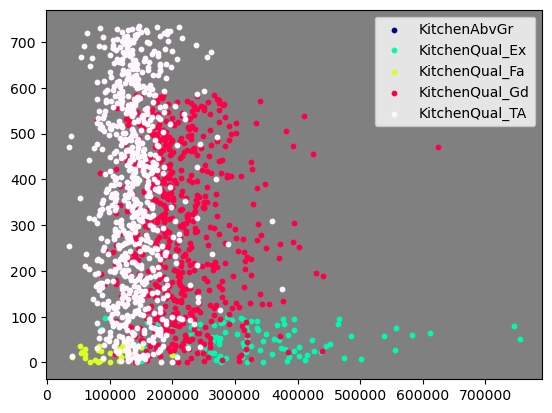

In [275]:
kitchens = [n for n in X_merged.columns if 'Kitchen' in n]
kitchen_ones = []
print(kitchens)
for n in kitchens:
    kitchen_ones.append(y[X_merged[X_merged[n] == 1][n].index])
    
fig, ax = plt.subplots()
index = 0
colors = cm.gist_ncar(np.linspace(0, 1, len(kitchen_ones)))
for no, c in zip(kitchen_ones, colors):
    ax.scatter(no, range(len(no)), label=kitchens[index], color=colors[index], s=10)
    index+=1
ax.set_facecolor((0.5,0.5,0.5))
ax.legend(loc='upper right');

- KitchenQual_Ex has more observations out of all kitchen features and naturally it would be a good feature, because we have a lot of data for the lower priced houses, and not for the expensive ones.

['BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_NA', 'BsmtQual_TA', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_NA', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_NA', 'BsmtExposure_No', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_NA', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_NA', 'BsmtFinType2_Rec']


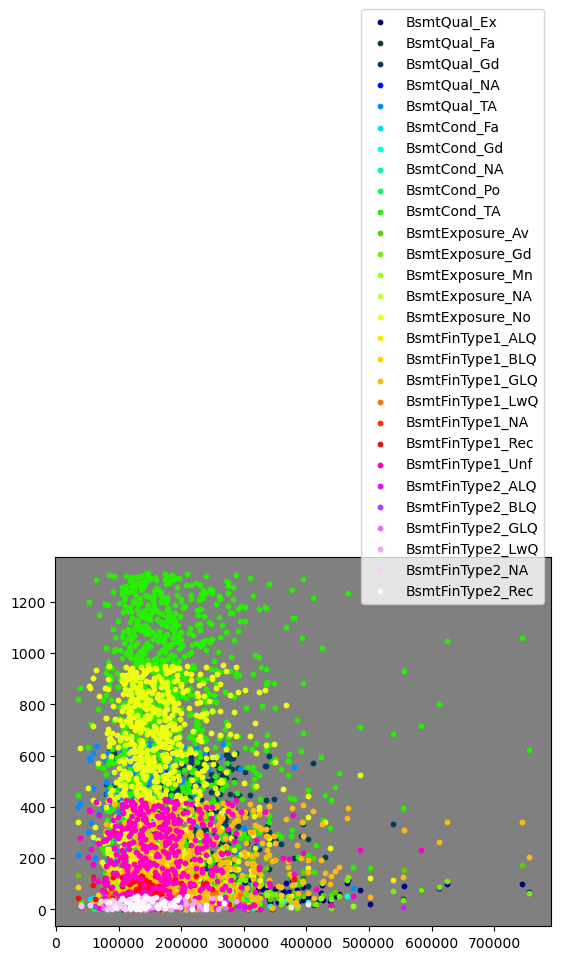

In [345]:
basements = [n for n in X_merged.columns if 'Bsmt' in n and X_merged[n].dtype=='uint8'] #The ones with 0 and 1s
basement_ones = []
basements.remove('BsmtFinType2_Unf')
print(basements)
for n in basements:
    basement_ones.append(y[X_merged[X_merged[n] == 1][:].index])
    
fig, ax = plt.subplots()
index = 0
colors = cm.gist_ncar(np.linspace(0, 1, len(basement_ones)))
for no, c in zip(basement_ones, colors):
    ax.scatter(no, range(len(no)), label=basements[index], color=colors[index], s=10)
    index+=1
ax.set_facecolor((0.5,0.5,0.5))
ax.legend(loc='upper right', bbox_to_anchor=(1, 2.5));

- Again, the sames applies to BsmtQual_Ex, it is a little more spread to the high end price houses than the other features.
- Now let's see how behaves numerical data.
- The top feature in backward sequential feature selection is OverallQual, so let's see that.

In [338]:
# There are two features that are a general appreciation of the house state
overall = [n for n in X_merged.columns if 'Overall' in n]
overall

['OverallQual', 'OverallCond']

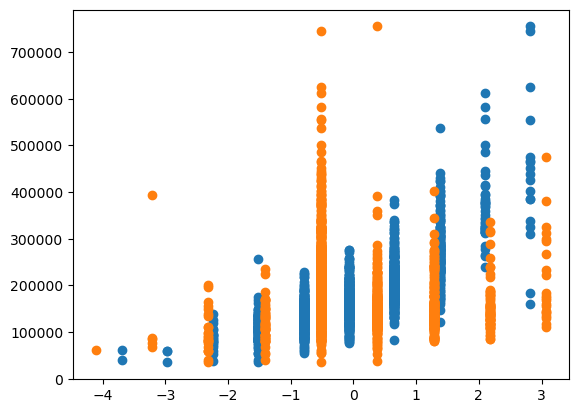

In [340]:
X1data = np.array(X_merged['OverallQual'])
X2data = np.array(X_merged['OverallCond'])
fig, ax = plt.subplots()
ax.scatter(X1data, y);
ax.scatter(X2data, y);

- Clearly, OverallQual has a better spread of the data because OverallCond has more density at the center, meaning that many houses are labeled the same.